# Introduction

In this notebook, I will be performing NLP machine learning on a dataset consisting of disaster tweets. The training data consists of 7613 rows with columns for id, keyword, location, text, and target. We will be focusing on NLP on the text attribute to predict the target

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# EDA

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [15]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


Text(0.5, 1.0, 'Distribution of labels')

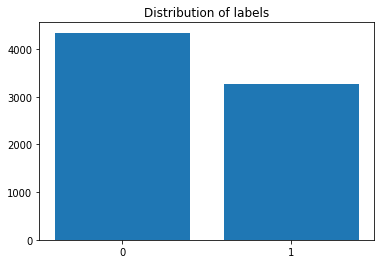

In [13]:
plt.bar(x=['0','1'], height=train_df['target'].value_counts())
plt.title('Distribution of labels for train data')

This seems to be a balanced dataset with approximately equal outcomes. Below I will be cleaning the text to remove urls, html text, and punctuations. I will then vectorize the text

In [45]:
#Cleaning text
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [46]:
train_df['text']=train_df['text'].apply(lambda x : remove_URL(x))
train_df['text']=train_df['text'].apply(lambda x : remove_html(x))
train_df['text']=train_df['text'].apply(lambda x : remove_punct(x))


In [47]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
corpus=create_corpus(train_df)        

100%|███████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 15856.83it/s]


In [49]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [50]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 16230


In [51]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|███████████████████████████████████████████████████████████████████████| 16230/16230 [00:00<00:00, 2704766.13it/s]


# Model

In [61]:
X=tweet_pad[:train_df.shape[0]]
y=train_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)


In [62]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           1623100   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,665,405
Trainable params: 42,305
Non-trainable params: 1,623,100
_________________________________________________________________


In [65]:
model_fit=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1523/1523 - 21s - loss: 0.6847 - accuracy: 0.5700 - val_loss: 0.6845 - val_accuracy: 0.5693 - 21s/epoch - 14ms/step
Epoch 2/15
1523/1523 - 20s - loss: 0.6838 - accuracy: 0.5706 - val_loss: 0.6899 - val_accuracy: 0.5693 - 20s/epoch - 13ms/step
Epoch 3/15
1523/1523 - 20s - loss: 0.6845 - accuracy: 0.5706 - val_loss: 0.6836 - val_accuracy: 0.5693 - 20s/epoch - 13ms/step
Epoch 4/15
1523/1523 - 20s - loss: 0.6842 - accuracy: 0.5706 - val_loss: 0.6836 - val_accuracy: 0.5693 - 20s/epoch - 13ms/step
Epoch 5/15
1523/1523 - 20s - loss: 0.6840 - accuracy: 0.5706 - val_loss: 0.6836 - val_accuracy: 0.5693 - 20s/epoch - 13ms/step
Epoch 6/15
1523/1523 - 20s - loss: 0.6841 - accuracy: 0.5706 - val_loss: 0.6836 - val_accuracy: 0.5693 - 20s/epoch - 13ms/step
Epoch 7/15
1523/1523 - 20s - loss: 0.6836 - accuracy: 0.5706 - val_loss: 0.6852 - val_accuracy: 0.5693 - 20s/epoch - 13ms/step
Epoch 8/15
1523/1523 - 20s - loss: 0.6838 - accuracy: 0.5706 - val_loss: 0.6845 - val_accuracy: 0.5693 - 20s/ep

# Conclusion/Discussion

This model is able to reach an accuracy of 0.5706, which means theres large room for improvement. The text can be cleaned a lot more thoroughly to remove unwanted symbols amd common words that do not add value to the text. 

In [86]:
test_df['text']=test_df['text'].apply(lambda x : remove_URL(x))
test_df['text']=test_df['text'].apply(lambda x : remove_html(x))
test_df['text']=test_df['text'].apply(lambda x : remove_punct(x))
corpus=create_corpus(test_df) 
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
word_index=tokenizer_obj.word_index
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
X=tweet_pad[:test_df.shape[0]]

100%|█████████████████████████████████████████████████████████████████████████| 9747/9747 [00:00<00:00, 3247944.79it/s]


In [116]:
test_pred=model.predict(X).round()
test_df['target']=test_pred
sub=test_df.drop(labels=['keyword', 'location', 'text'], axis=1)
sub.to_csv('test_result.csv', index=False)